In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
# get undefined class number
def get_undefined_class_number():
    excluded_classes = {3, 4, 5}
    while True:
        random_class = random.randint(1, 196)
        if random_class not in excluded_classes:

            return random_class

# get images and labels
def get_images_and_labels():
  images= []
  labels= []
  desired_classes = [3,4,5] + [undefined_class]

  for index, row in df_train.iterrows():
    is_desired_class = row['Class'] in desired_classes
    if(is_desired_class):
      image = cv2.imread(os.path.join(path_train,row["image"]))
      image = crop_car(image, row['x1'], row['y1'], row['x2'], row['y2'])
      images.append(image)
      labels.append(row['Class'])

  return images,labels

# plot hist classes
def plot_hist_labels(labels):
  counter = Counter(labels)

  x = [str(num) for num in sorted(counter.keys())]
  y = list(counter.values())
  plt.bar(x, y, color='black')
  plt.xlabel("Classes")
  plt.ylabel("Ocorrências")


def rotate_image_randomly(image):
    (h, w) = image.shape[:2]
    angle = random.uniform(-10, 10)
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

    return rotated_image

def random_resize(image, scale_range=(0, 0.05)):
    (h, w) = image.shape[:2]
    scale_factor = 1 + random.uniform(scale_range[0], scale_range[1])
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    return resized_image

def horizontal_flip(image, noise_factor=0.05):
    flipped_image = cv2.flip(image, 1)
    noise = np.random.normal(loc=0, scale=noise_factor, size=flipped_image.shape)
    noisy_image = flipped_image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def adjust_contrast(image, alpha=1.5):
    image_float = image.astype(np.float32)
    adjusted_image = cv2.convertScaleAbs(image_float, alpha=alpha, beta=0)

    return adjusted_image

# pre process image
def pre_process_image(image):
  imagenet_mean = [0.485, 0.456, 0.406]
  imagenet_std = [0.229, 0.224, 0.225]

  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.0
 # image = (image - imagenet_mean) / imagenet_std

  return cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

# perform data augmentation
def data_augmentation(images, labels):
    augmented_images = []
    augmented_labels = []
    augment_funtions=[rotate_image_randomly,random_resize,horizontal_flip,adjust_contrast]

    for i in range(len(images)):
        augmented_images.append(pre_process_image(images[i]))
        augmented_labels.append(labels[i])

        for _ in range(4):
          for augment_funtion in augment_funtions:
            augmented_images.append(pre_process_image(augment_funtion(images[i])))
            augmented_labels.append(labels[i])

    return np.array(augmented_images), np.array((augmented_labels))

# pre proces test data
def pre_process_test_data(images,labels):
  processed_images=[]
  labels_ = []
  for i,image in enumerate(images):
    processed_image=pre_process_image(image)
    processed_images.append(processed_image)
    labels_.append(labels[i])


  return np.array(processed_images),np.array((labels))

# list files
def list_files(directory):
  files = os.listdir(directory)

  return files

# map labels
def map_labels(labels):
  label_mapping = { 3: 0, 4: 1, 5: 2,undefined_class: 3}
  mapped_labels = np.array([label_mapping[label] for label in labels])

  return mapped_labels

# crop car images
def crop_car(image, x1, y1, x2, y2):
    points = np.array([
        [x1, y1],
        [x2, y1],
        [x2, y2],
        [x1, y2]
    ], dtype="float32")
    width = int(max(np.linalg.norm(points[1] - points[0]), np.linalg.norm(points[2] - points[3])))
    height = int(max(np.linalg.norm(points[0] - points[3]), np.linalg.norm(points[1] - points[2])))
    dest_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    matrix = cv2.getPerspectiveTransform(points, dest_points)
    cropped_image = cv2.warpPerspective(image, matrix, (width, height))
    return cropped_image

# plot one image per class
def plot_one_image_per_class(images, labels,is_processed):
    unique_classes = np.unique(labels)
    class_images = {}

    for label in unique_classes:
        index = np.where(labels == label)[0][0]
        class_images[label] = images[index]

    number_of_classes = len(unique_classes)
    fig, axes = plt.subplots(1, number_of_classes, figsize=(5 * number_of_classes, 5))


    for ax, cls in zip(axes, unique_classes):
      if is_processed:
        ax.imshow((class_images[cls] * 255).astype(np.uint8))
        ax.axis('off')
      else:
        ax.imshow(cv2.cvtColor(class_images[cls], cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Classe: {cls}")

# train CNN model
def train_model(base_model):
  number_of_classes = len(np.unique(y_train))
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  output = keras.layers.Dense(number_of_classes, activation='softmax')(x)
  model = keras.models.Model(inputs=[base_model.input], outputs=[output])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])


  patience = 1
  stop_patience = 3
  factor = 0.5

  callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
  ]

  history = model.fit(
                    X_train, to_categorical(y_train,num_classes=number_of_classes), batch_size=16,
                    epochs=15,validation_data=(X_test, to_categorical(y_test,num_classes=number_of_classes)),
                    callbacks=callbacks
                    )

  return model, history.history

# plot accuracy from model
def plot_accuracy_from_history(history):
  plt.plot(history['accuracy'], label='Treinamento')
  plt.plot(history['val_accuracy'], label='Teste')
  plt.xlabel('Época')
  plt.ylabel('Acurácia')
  plt.legend()

# plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
  plt.xlabel("Predito");
  plt.ylabel("Real");

# Leitura do conjunto de dados

* A primeira etapa do defesafio proposto consistiu em definir o que seria a classe "indefinida", nesse contexto, surgem as seguintes possibilidades:
  


```
*  Uma classe selecionada de forma aleatória do conjunto de dados;
*  Utilizar todas as classes restantes como classe indefinidia;
*  Utilizar imagens de outro conjunto de dados para tratar imagens que não são relacionadas a carros.

```

 * Por questão de simplicidade, a primeira opção foi adotada. Desse modo, é selecionado de forma aleatória um número diferente de 3, 4 e 5.

In [ ]:
undefined_class = get_undefined_class_number()

In [ ]:
path_train="data/cars_train/cars_train"

* No link disponibilizado, não havia a rotulação de qual classe cada imagem pertencia. Foi utilizada a rotulação presente nesse [repositório](https://github.com/BotechEngineering/StanfordCarsDatasetCSV/blob/main/cardatasettrain.csv).

* Como apenas o arquivo `.csv` cardatasettrain.csv apresenta a classe à qual cada imagem pertence, apenas as imagens presentes no diretório de treinamento foram utilizadas.



In [8]:
df_train=pd.read_csv("cardatasettrain.csv")
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.tail()

,x1,y1,x2,y2,Class,image
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg
8143,20,240,862,677,17,08144.jpg


In [ ]:
files_in_train = list_files(path_train)

In [ ]:
images,labels = get_images_and_labels()

# Exploração de conjunto de dados

* Ao selecionar um número de classe, o escolhido foi o número 60.

* Antes de realizar a etapa de treinamento de qualquer modelo de classificação, é de vital importância realizar uma inspeção mínima no conjunto de dados para verificar questões como qualidade das imagens, balanceamento das classes, etc.

* Inicialmente, foi observada a distribuição das imagens por classe. Essa verificação foi feita por meio da observação do histograma de cada classe. Ambas as classes apresentaram quantidades relativamente equivalentes, não sendo necessário o uso de alguma técnica de balanceamento. Entretanto, a quantidade de imagens é relativamente pequena para treinar uma rede convolucional profunda, dada a quantidade de parâmetros a serem ajustados. Tal fato pode acarretar a ocorrência de *overfitting*, levando o modelo treinado a ser tendencioso.tendenciososo.

* Outro ponto verificado é que algumas imagens apresentam palavras. Isso pode acabar prejudicando o processo de aprendizagem do modelo a ser treinado. Por sorte, o conjunto de dados disponibiliza as coordenadas das marcações dos carros. Dessa forma, é possível realizar o recorte apenas do carro, permitindo que o modelo foque apenas no objeto de interesse.

* Após a realização do recorte do carro, as imagens tiveram seus pixels normalizados entre 0 e 1, esse procedimento toda  treinamento mais estável e eficiente. Além disso, as imagens foram redimensionadas para a resolucao de `224x224`.

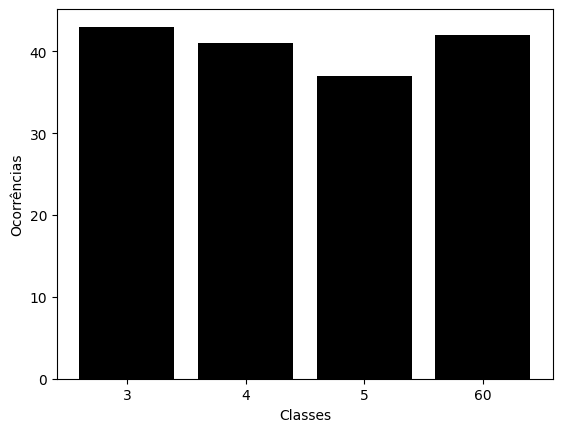

In [ ]:
plot_hist_labels(labels)

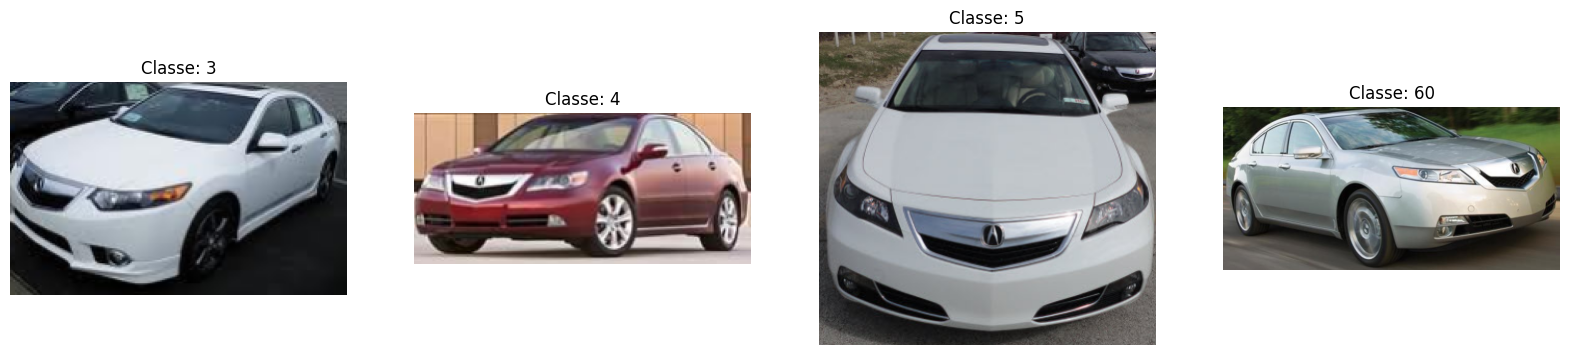

In [ ]:
plot_one_image_per_class(X_train, labels,False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, map_labels(labels), test_size=0.3, random_state=42)

* Diante da pouca quantidade de imagens disponíveis para cada classse, foi utilizado o process de *data augmentation*, essa técnica tem vital importancia para o sucesso do processo de treinamento do modelo, uma vez que ele melhora a generalização do modelo, reduz o *overfitting*, aumenta a quantidade de dados disponíveis, tornando o modelo mais robusto e preciso. Nesse contexto, as seguintes transformações foram aplicadas :


  * Rotação aleatória: A imagem é rotacionada em um intervalo aleatório de -10 a 10 graus ao redor do centro da imagem.

  * Redimensionamento aleatório: A imagem é redimensionada aleatoriamente, com um fator de escala que varia entre 0 e 5% do tamanho original.

  * Espelhamento horizontal: A imagem é invertida horizontalmente, criando um reflexo ao longo do eixo vertical central com adição de ruído.

* Por questão de ordem, a classe 3 passou a se chamar 0, a classe 4 tornou-se 1, a classe 5 tornou-se 2 e a classe 60 tornou-se 3.


In [ ]:
X_train, y_train = data_augmentation(X_train, y_train)

In [ ]:
X_test,y_test=pre_process_test_data(X_test,y_test)

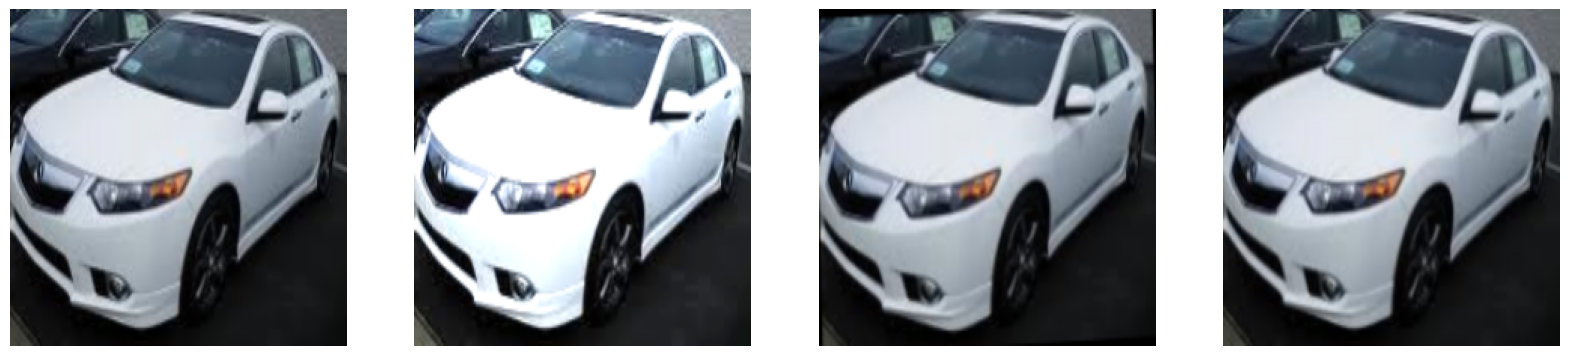

In [ ]:
plot_one_image_per_class(X_train,labels,True)

In [ ]:
del images
del labels

In [ ]:
print("Conjunto de treinamento", len(X_train))
print("Conjunto de teste", len(X_test))

Conjunto de treinamento 1938
Conjunto de teste 49


# Treinamento do modelo

*  A arquitetura escolhida para realizar a classifição das imagens foi a **EfficientNetB1**.

* Os seguintes parâmetros foram utilizados no processo de treinamento:

* Taxa de aprendizagem: 0.001

* Otimizador: Adam

* *EarlyStopping*: Utilizada para regularização usada para evitar o *overfitting* durante o treinamento de um modelo, interrompendo o processo de treinamento no momento oportuno. Em sua aplicação, a métrica observada foi o val_loss (valor da função de erro para o conjunto de teste). Se o erro não reduzir por 3 épocas seguidas, o treinamento é interrompido.

* A taxa de aprendizagem é reduzida quando o valor da função de erro para o conjunto de teste não sofre redução, nesse contexto, a taxa de aprendizado é diminuída pela metade.

 -  Esse procedimento tem uma importância relevante no processo de treinamento, visto que, quando o modelo chega a um ponto onde a função de erro não melhora, isso pode indicar que a taxa de aprendizagem é muito alta, fazendo com que o modelo "pule" a solução ótima. Ao diminuir a taxa de aprendizagem, o modelo tem a capacidade de realizar ajustes mais finos e procurar a solução de forma mais precisa, sem saltar para longe do mínimo global.





In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model,history = train_model(keras.applications.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
))

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8621 - loss: 0.3581 - val_accuracy: 0.2245 - val_loss: 1.3746 - learning_rate: 0.0010
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9835 - loss: 0.0601
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
122/122 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9836 - loss: 0.0600 - val_accuracy: 0.3469 - val_loss: 4.0544 - learning_rate: 0.0010
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9921 - loss: 0.0389
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
122/122 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9921 - loss: 0.0389 - val_accuracy: 0.2449 - val_loss: 1.5962 - learning_rate: 5.0000e-04
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.6327 - val_loss: 0.7999 - learning_rate: 2.5000e-04
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9986 - loss: 

In [ ]:
model.save("car_classification_model.keras") # salvando modelo

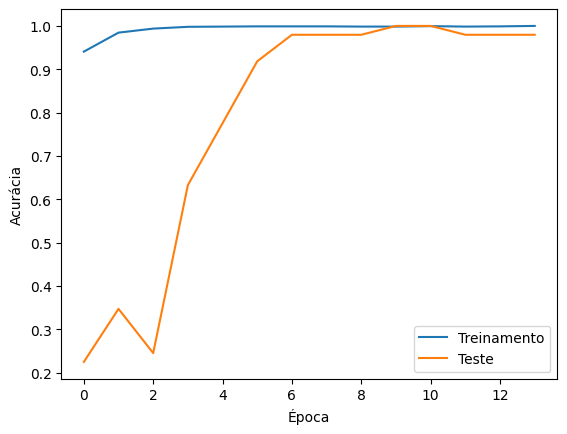

In [ ]:
plot_accuracy_from_history(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred=y_pred.argmax(axis=-1) # convertendo as probabilidades de cada classe em um rótulo

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


* Observando os resultados obtidos, nota-se que apenas uma imagem foi classificada de forma errada, ocorrendo uma confusão entre as classes 1 e 2, conforme ilustrado pela **matriz de confusão**.

* Para a classe 1, a precisão (precision) atingida foi de 100%, indicando que, de todas as imagens que o modelo classificou como positivas (classe 1), todas realmente pertenciam à classe positiva. Ou seja, não houve nenhum falso positivo.

* Ainda para a classe 1, observando a revocação (recall)  obtido, é possível inferir que o modelo conseguiu identificar corretamente 91% de todas as imagens positivas (classe 1) que realmente pertencem à classe positiva. Ou seja, de todos os exemplos que são realmente da classe positiva, 91% foram corretamente classificados pertencentes a classe 1, indicando que imagens da classe 1 foram classificadas como pertencentes a outra classe.

* O valor de F1-Score obtido, 0.95 (95%), ilustra que o modelo consegue ter um bom desempenho para evitar falsos negativos e falsos positivos, uma vez que essa métrica consiste em uma média ponderada das métrcias precision e recall.


* Para a classe 2, uma análise similar pode ser aplicada. Porém, a precisão (precision) foi de 92%, ao passo que o recall foi de 100%.

* A classes restantes foram diferenciadas com sucesso, não havendo confusão entre elas.

* Observando a média dos resultados, a acurácia média foi de 98%, indicando uma boa capacidade de distinção entre as classes, o que é reforçado pelo F1-Score obtido de também 98%, sinalizando que o modelo de fato tem uma capacidade de evitar falsos positivos e falsos negativos em ambas as classes.


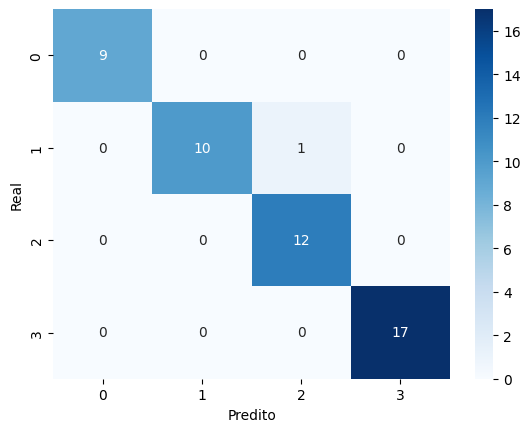

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["0","1","2","3"],zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        12
           3       1.00      1.00      1.00        17

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

